<a href="https://colab.research.google.com/github/kinue00/KG_Eval/blob/main/Experiments_KG_with_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook belongs to a knowledge graph evalutation project -- some link.

In [ ]:
from google.colab import files

!pip freeze > requirements.txt
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Set up and imports

In [ ]:
# Line Wrapping in Colab
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# An elegant way to view JSON data
import json
from IPython.display import HTML, display

def view_json(data):
    """
    Display JSON data as an interactive, collapsible tree in Google Colab.

    Args:
    data (dict or str): JSON data to display. Can be a Python dictionary or a JSON string.
    """
    if isinstance(data, str):
        data = json.loads(data)

    # escape the semicolon using a backslash
    html_content = """
    <script src="https://cdnjs.cloudflare.com/ajax/libs/jsoneditor/9.9.2/jsoneditor.min.js"></script>
    <link href="https://cdnjs.cloudflare.com/ajax/libs/jsoneditor/9.9.2/jsoneditor.min.css" rel="stylesheet" type="text/css">
    <div id="jsoneditor" style="width: 100%%; height: 400px;"></div>
    <script>
        var container = document.getElementById("jsoneditor");
        var options = {
            mode: 'tree',
            modes: ['tree', 'view', 'form', 'code', 'text', 'preview'],
            onError: function (err) {
                alert(err.toString());
            }
        };
        var editor = new JSONEditor(container, options);
        var json = %s;
        editor.set(json);
        editor.expandAll();
    </script>
    """ % json.dumps(data)

    display(HTML(html_content))

In [ ]:
!pip install llama_index llama-index-llms-perplexity pyvis wikipedia llama-index-graph-stores-neo4j treelib



In [ ]:
from llama_index.core import Document, PropertyGraphIndex
from llama_index.core.indices.property_graph import (
    SimpleLLMPathExtractor,
    SchemaLLMPathExtractor,
    DynamicLLMPathExtractor,
)
from llama_index.llms.perplexity import Perplexity
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings

import wikipedia

import os

In [ ]:
import nest_asyncio

nest_asyncio.apply()

### LLM set up

In [ ]:
# set up OpenAI model as the llm to request
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# Set up global configurations
llm = OpenAI(temperature=0.0, model="gpt-4o-mini")

Settings.llm = llm
Settings.chunk_size = 200
Settings.chunk_overlap = 20

### Neo4j DB set up

In [ ]:
# Neo4j DB set up
from llama_index.graph_stores.neo4j import Neo4jPGStore

username="neo4j"
password=userdata.get('PW_NEO4J')
url=userdata.get('URI_NEO4J')

graph_store = Neo4jPGStore(
    username=username,
    password=password,
    url=url,
)

# 0. Test out LLM LLM Path Extractors for Knowledge Graph Construction from Llamaindex


Just skip this section, begin at §1.

Setup LLM backend

*   We are using llama 3.1 chat model with a context window of 131,072 tokens




In [ ]:
from google.colab import userdata

pplx_api_key = userdata.get('PPLX_API_KEY')

llm = Perplexity(
    api_key=pplx_api_key,
    model="llama-3.1-sonar-large-128k-chat",
    temperature=0.5,
    # max_retries = 3,
    # additional_kwargs = {"timeout": 60}
)

Settings.llm = llm
Settings.chunk_size = 2048
Settings.chunk_overlap = 20

In [ ]:
dir(llm)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__class_vars__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__fields__',
 '__fields_set__',
 '__format__',
 '__ge__',
 '__get_pydantic_core_schema__',
 '__get_pydantic_json_schema__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pretty__',
 '__private_attributes__',
 '__pydantic_complete__',
 '__pydantic_core_schema__',
 '__pydantic_custom_init__',
 '__pydantic_decorators__',
 '__pydantic_extra__',
 '__pydantic_fields_set__',
 '__pydantic_generic_metadata__',
 '__pydantic_init_subclass__',
 '__pydantic_parent_namespace__',
 '__pydantic_post_init__',
 '__pydantic_private__',
 '__pydantic_root_model__',
 '__pydantic_serializer__',
 '__pydantic_validator__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__repr_a

## 0.0. Tests for LLM API references (chat)

In [ ]:
# Test out Perplexity API reference
import requests

url = "https://api.perplexity.ai/chat/completions"

payload = {
    "model": "llama-3.1-sonar-large-128k-chat",
    "messages": [
        {
            "role": "system",
            "content": "Be precise and concise."
        },
        {
            "role": "user",
            "content": "How many stars are there in our galaxy?"
        }
    ],
    # "max_tokens": 131072,
    "temperature": 0.2,  # The amount of randomness in the response, valued between 0 inclusive and 2 exclusive. Higher values are more random, and lower values are more deterministic.
    "top_p": 0.9,  # The nucleus sampling threshold, valued between 0 and 1 inclusive. For each subsequent token, the model considers the results of the tokens with top_p probability mass. We recommend either altering top_k or top_p, but not both.
    "return_citations": False,
    "search_domain_filter": ["perplexity.ai"],
    "return_images": False,
    "return_related_questions": False,
    "search_recency_filter": "month",
    "top_k": 0,  # The number of tokens to keep for highest top-k filtering, specified as an integer between 0 and 2048 inclusive. If set to 0, top-k filtering is disabled. We recommend either altering top_k or top_p, but not both.
    "stream": False,  # Determines whether or not to incrementally stream the response with server-sent events with content-type: text/event-stream.
    "presence_penalty": 0,  # A value between -2.0 and 2.0. Positive values penalize new tokens based on whether they appear in the text so far, increasing the model's likelihood to talk about new topics. Incompatible with frequency_penalty.
    "frequency_penalty": 1  # A multiplicative penalty greater than 0. Values greater than 1.0 penalize new tokens based on their existing frequency in the text so far, decreasing the model's likelihood to repeat the same line verbatim. A value of 1.0 means no penalty. Incompatible with presence_penalty.
}
headers = {
    "Authorization": f"Bearer {pplx_api_key}",
    "Content-Type": "application/json"
}

response = requests.request("POST", url, json=payload, headers=headers)

view_json(response.json())

In [ ]:
response.json()['choices'][0]['message']['content']

'Estimates suggest that there are between 200 and 400 billion stars in the Milky Way galaxy. However, the exact number is still a subject of ongoing research and refinement.'

In [ ]:
# Test out LlamaIndex wrapping of PPLX API chat
from llama_index.core.llms import ChatMessage

messages_dict = [
    {"role": "system", "content": "Be precise and concise."},
    {"role": "user", "content": "Tell me 5 sentences about Perplexity."},
]
messages = [ChatMessage(**msg) for msg in messages_dict]

response = llm.chat(messages)
print(response)

assistant: Perplexity is a measure of how well a probability model predicts a test dataset. It is often used in natural language processing and information theory to evaluate the performance of language models. A lower perplexity score indicates better predictive performance, while a higher score suggests poorer performance. Perplexity is calculated as the exponential of the average negative log-likelihood of the test data. It provides a way to compare different models on their ability to predict unseen data.


Perplexity api turns out to has a low rate limit and it possibly not doesn't fit for KG extraction, so we just use OpneAI's service.

In [ ]:
# set up OpenAI model as the llm to request
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# Set up global configurations
llm = OpenAI(temperature=0.0, model="gpt-4o-mini")

Settings.llm = llm
Settings.chunk_size = 2048
Settings.chunk_overlap = 20

In [ ]:
# Test out OpenAI integration in LlamaIndex for chat
response = llm.chat(messages)
print(response)

assistant: 1. Perplexity is a state of being confused or puzzled, often resulting from a lack of understanding or clarity.
2. It can arise when faced with complex or contradictory information, leading to uncertainty or indecision.
3. Perplexity is a common human experience that can occur in various situations, such as when trying to solve a difficult problem or make a challenging decision.
4. It may also be a temporary feeling that can be resolved through further exploration, reflection, or seeking help from others.
5. Coping with perplexity can help individuals develop critical thinking skills and deepen their understanding of complex issues.


Check for OpenAI api rate limits

In [ ]:
!pip install openai

In [ ]:
from openai import OpenAI
client = OpenAI()

response = client.chat.completions.with_raw_response.create(
    messages=[{
        "role": "user",
        "content": "Say this is a test",
    }],
    model="gpt-3.5-turbo",
)

In [ ]:
# Access rate limit headers
rate_limit_limit = response.headers.get('x-ratelimit-limit-requests')
rate_limit_remaining = response.headers.get('x-ratelimit-remaining-requests')
rate_limit_reset = response.headers.get('x-ratelimit-reset-requests')

print(f"Rate Limit: {rate_limit_limit}")
print(f"Remaining Requests: {rate_limit_remaining}")
print(f"Reset Time: {rate_limit_reset}")

Rate Limit: 10000
Remaining Requests: 9999
Reset Time: 6ms


## 0.1. Fetch Raw Text from Wikipedia
For starter, we use the wikipedia page for Heike Monogatari (English) as source text to generate KG from.

In [ ]:
def get_wikipedia_content(title):
    try:
        page = wikipedia.page(title)
        return page.content
    except wikipedia.exceptions.DisambiguationError as e:
        print(f"Disambiguation page. Options: {e.options}")
    except wikipedia.exceptions.PageError:
        print(f"Page '{title}' does not exist.")
    return None

In [ ]:
wiki_title = "The Tale of the Heike"
content = get_wikipedia_content(wiki_title)

if content:
    document = Document(text=content, metadata={"title": wiki_title})
    print(
        f"Fetched content for '{wiki_title}' (length: {len(content)} characters)"
    )
else:
    print("Failed to fetch Wikipedia content.")

Fetched content for 'The Tale of the Heike' (length: 32837 characters)


In [ ]:
document.text[:500]

'The Tale of the Heike (平家物語, Heike Monogatari) is an epic account compiled prior to 1330 of the struggle between the Taira clan and Minamoto clan for control of Japan at the end of the 12th century in the Genpei War (1180–1185).\nIt has been translated into English at least five times. The first translation was by Arthur Lindsay Sadler, in 1918–1921. A complete translation in nearly 800 pages by Hiroshi Kitagawa & Bruce T. Tsuchida was published in 1975. It was also translated by Helen McCullough'

## 0.2. SimpleLLMPathExtractor
No predefined KG schemas, LLM extract it on the fly. For visualization, the KG is stored in a Neo4j database for querying.

In [ ]:
# Neo4j DB set up
from llama_index.graph_stores.neo4j import Neo4jPGStore

username="neo4j"
password=userdata.get('PW_NEO4J')
url=userdata.get('URI_NEO4J')

graph_store = Neo4jPGStore(
    username=username,
    password=password,
    url=url,
)

In [ ]:
kg_extractor = SimpleLLMPathExtractor(
    llm=llm, max_paths_per_chunk=20, num_workers=4
)

simple_index = PropertyGraphIndex.from_documents(
    [document],
    llm=llm,
    embed_kg_nodes=False,
    kg_extractors=[kg_extractor],
    property_graph_store=graph_store,
    show_progress=True,
)

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting paths from text: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


## 0.3 SchemaLLMPathExtractor
It seems that the KG extracted without inital ontology is a mess. the definition of the schema of a KG is very subjective and in the end, KG is a tool designated to the envisionned application.

In [ ]:
from typing import Literal

# best practice to use upper-case
entities = Literal["CLAN", "BUDDHIST_TEMPLE", "IMPERIAL_COURT", "PERSON", "EVENT", "CHAPTER"]
relations = Literal["HAS_MEMBER", "HAS_PARENT", "HAS_SPOUSE", "HAS_CHILD", "HAS_PARTICIPANT", "IS_PART_OF", "MENTIONS_PERSON", "DESCRIBES_EVENT"]

# define which entities can have which relations
validation_schema = [
    ("CLAN", "HAS_MEMBER", "PERSON"),
    ("BUDDHIST_TEMPLE", "HAS_MEMBER", "PERSON"),
    ("IMPERIAL_COURT", "HAS_MEMBER", "PERSON"),
    ("PERSON", "HAS_PARENT", "PERSON"),
    ("PERSON", "HAS_SPOUSE", "PERSON"),
    ("PERSON", "HAS_CHILD", "PERSON"),
    ("EVENT", "HAS_PARTICIPANT", "PERSON"),
    ("EVENT", "IS_PART_OF", "EVENT"),
    ("CHAPTER", "MENTIONS_PERSON", "PERSON"),
    ("CHAPTER", "DESCRIBES_EVENT", "EVENT"),
]

entity_props = [
    ("FAMILY_NAME", "the family name of a PERSON"),
    ("GIVEN_NAME", "the given name of a PERSON"),
    ("BIRTH_DATE", "the birth date of a PERSON"),
    ("DEATH_DATE", "the death date of a PERSON"),
    ("DATE_OF_OCCURRENCE", "the date of occurrence of an EVENT"),
    ("PLACE_OF_OCCURRENCE", "the place of occurrence of an EVENT"),
    ("TITLE", "the title of a CHAPTER"),
]

kg_extractor = SchemaLLMPathExtractor(
    llm=llm,
    possible_entities=entities,
    possible_relations=relations,
    possible_entity_props=entity_props,
    kg_validation_schema=validation_schema,
    # if false, allows for values outside of the schema
    # useful for using the schema as a suggestion
    strict=True,
    num_workers=4,
)

In [ ]:
index = PropertyGraphIndex.from_documents(
    [document],
    llm=llm,
    kg_extractors=[kg_extractor],
    embed_kg_nodes=False,
    property_graph_store=graph_store,
    show_progress=True,
)

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting paths from text with schema:   6%|▌         | 1/18 [00:03<00:58,  3.46s/it]

KeyboardInterrupt: 

# 1. Experiments
In this section, we will extract KGs from text based documents, explore them in Neo4j DB and try to evaluate them with a systematic approach.

## 1.1. Simple interpersonal relationship KG from a wikipedia page
For starter, we extract a KG capturing family relationships from the wikipedia page of *Heike Monogatari* character list and validate it against existing genealogies for Taira and Minamoto.

In [ ]:
def get_wikipedia_content(title):
    try:
        page = wikipedia.page(title)
        return page.content
    except wikipedia.exceptions.DisambiguationError as e:
        print(f"Disambiguation page. Options: {e.options}")
    except wikipedia.exceptions.PageError:
        print(f"Page '{title}' does not exist.")
    return None

In [ ]:
wiki_title = "List of The Tale of the Heike characters"
content = get_wikipedia_content(wiki_title)

if content:
    document = Document(text=content, metadata={"title": wiki_title})
    print(
        f"Fetched content for '{wiki_title}' (length: {len(content)} characters)"
    )
else:
    print("Failed to fetch Wikipedia content.")

Fetched content for 'List of The Tale of the Heike characters' (length: 10413 characters)


In [ ]:
document.text[:500]

'This is a list of the characters that appear in The Tale of the Heike.\n\n\n== A ==\nArio, a loyal page boy in the service of Shunkan, who looked after him since he was young.  He sought Shunkan out at Kikai-ga-shima and looked after him during his exile.\nTaira no Atsumori, a young warrior known for his death in single combat at the hands of Kumagae no Jirô Naozane.  He was well known for his skill with the flute.\n\n\n== B ==\nSaito Musashibo Benkei, a Sohei who served Minamoto no Yoshitsune.  He is kn'

In [ ]:
entities = Literal["PERSON", "CLAN"]
relations = Literal["HAS_MEMBER", "HAS_PARENT", "HAS_SPOUSE", "HAS_SIBLING", "HAS_CHILD"]

validation_schema = [
    ("CLAN", "HAS_MEMBER", "PERSON"),
    ("PERSON", "HAS_PARENT", "PERSON"),
    ("PERSON", "HAS_SPOUSE", "PERSON"),
    ("PERSON", "HAS_SIBLING", "PERSON"),
    ("PERSON", "HAS_CHILD", "PERSON"),
]

entity_props = [
    ("FAMILY_NAME", "the family name of a PERSON"),
    ("GIVEN_NAME", "the given name of a PERSON"),
]

kg_extractor = SchemaLLMPathExtractor(
    llm=llm,
    possible_entities=entities,
    possible_relations=relations,
    possible_entity_props=entity_props,
    kg_validation_schema=validation_schema,
    strict=True,
    num_workers=4,
    max_triplets_per_chunk=20,
)

index = PropertyGraphIndex.from_documents(
    [document],
    llm=llm,
    kg_extractors=[kg_extractor],
    embed_kg_nodes=False,
    property_graph_store=graph_store,
    show_progress=True,
)

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting paths from text with schema: 100%|██████████| 18/18 [00:52<00:00,  2.90s/it]


The result looks like this (only a subgraph of the whole KG):

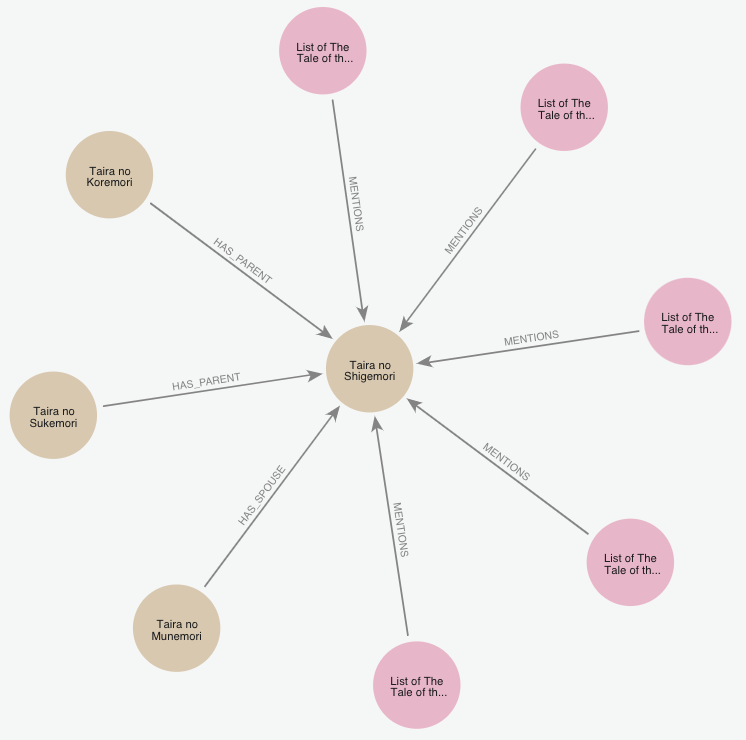

The brown nodes represent person and the pink ones are text chunks which we don't need in our application. In order to delete the nodes typed "Chunk" and their associated relations, run this Cypher query in your Aura terminal:

```
MATCH (n:Chunk)
DETACH DELETE n
```

Another Issue in terms of format of rerepresenting the graph is that a node has multiple types. for example the node for *Kiyomori Taira* has 3 types: PERSON, \_\_Entity\_\_ and \_\_Node\_\_.
Get rid of this by typing following command:
```
MATCH (n)
WHERE n:__Node__ OR n:__Entity__
REMOVE n:__Node__:__Entity__;
```

We also spotted that CLAN typed nodes have PERSON type label, simple search for CLAN in explore tab in your Aura workspace and edit it out manually.

## 1.2. Create Family Tree from simple KG

In [ ]:
from neo4j import GraphDatabase
from treelib import Tree

def create_family_tree(uri, username, password):
    # Connect to Neo4j
    driver = GraphDatabase.driver(uri, auth=(username, password))

    # Create a tree
    tree = Tree()

    # Query to get all relationships
    # Start from root (person without parents)
    query = """
    MATCH (root:PERSON)
    WHERE NOT (root)-[:HAS_PARENT]->()
    OPTIONAL MATCH path = (root)<-[:HAS_PARENT*]-(descendant:PERSON)
    RETURN root.name as root_name,
           COLLECT(DISTINCT [node in nodes(path) | node.name]) as paths
    """

    with driver.session() as session:
        result = session.run(query)
        records = list(result)

        for record in records:
            root_name = record["root_name"]
            paths = record["paths"]

            # Add root node
            tree.create_node(root_name, root_name)

            # Add all paths from root to descendants
            for path in paths:
                if path:  # Skip empty paths
                    for i in range(len(path)-1):
                        parent = path[i]
                        child = path[i+1]
                        if not tree.contains(child):
                            tree.create_node(child, child, parent=parent)

    driver.close()
    return tree

# Create and display the tree
family_tree = create_family_tree(url, username, password)
family_tree.show()

AuthError: {code: Neo.ClientError.Security.Unauthorized} {message: The client is unauthorized due to authentication failure.}

## 1.3. Knowledge Graph with Structured Outputs
What LlamaIndex offer as KG generation method didn't perform well as we expected. The problem is that it is highly dependent on the input document and this switching from text to KG directly (at least for default extractor in LlamaIndex) is, as we saw in §1.1., prone to differ from the schema that we defined.

From [Together Cookbook](https://https://github.com/togethercomputer/together-cookbook) I find a way to restrict the output of LLM using Pydantic in JSON format.
Consider it a new start, LlamaIndex is dead and longlive Together.ai!

In [ ]:
!pip install together graphviz

In [ ]:
from together import Together
import together
import os, json
from google.colab import userdata
from pydantic import BaseModel, Field
from typing import List
from enum import Enum
from graphviz import Digraph
from google.colab import files
from google.colab import userdata

TOGETHER_API_KEY = userdata.get('TOGETHER_AI_KEY')

Definition of schema in JSON

In [ ]:
class Node(BaseModel, frozen=True):
    id: int
    label: str

class RestrictedLabel(str, Enum):
    HAS_PARENT = "HAS_PARENT"
    HAS_SPOUSE = "HAS_SPOUSE"
    HAS_CHILD = "HAS_CHILD"
    HAS_SIBLING = "HAS_SIBLING"

class Edge(BaseModel, frozen=True):
    source: int
    target: int
    label: RestrictedLabel

class KnowledgeGraph(BaseModel):
    nodes: List[Node] = Field(..., default_factory=list)
    edges: List[Edge] = Field(..., default_factory=list)

KnowledgeGraph.model_json_schema()

In [ ]:
# Visulize KG with Graphviz
def visualize_knowledge_graph(kg):
    dot = Digraph(comment="Knowledge Graph", format='png')

    # Add nodes
    for node in kg['nodes']:
        dot.node(str(node['id']), node['label'])

    # Add edges
    for edge in kg['edges']:
        dot.edge(str(edge['source']), str(edge['target']), label=edge['label'])

    # Render the graph to a file and open it
    output_path = dot.render("knowledge_graph", view=True)
    print(f"Graph rendered and saved to {output_path}")

# Call the LLM with the JSON schema
def generate_graph(input) -> KnowledgeGraph:
    together = Together(api_key = TOGETHER_API_KEY)

    extract = together.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f"""Create a family relationship knowledge graph for characters in {input}.
                 Only answer in JSON and follow these rules:
                 Edges must use one of these labels: HAS_PARENT, HAS_SPOUSE, HAS_CHILD, or HAS_SIBLING."""
            }
        ],
        model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",
        response_format={
            "type": "json_object",
            "schema": KnowledgeGraph.model_json_schema(),
        },
    )

    output = json.loads(extract.choices[0].message.content)
    return output

In [ ]:
graph = generate_graph("The Tale of Heike")
# print(graph)

with open('output.json', 'w') as f:
    json.dump(graph, f)
files.download('output.json')

visualize_knowledge_graph(graph)
display(Image(filename='/content/knowledge_graph.png'))